# Module 6: 特徵創造 - 3. 時間衍生特徵 (Time-Derived Features)

## 學習目標
- 理解時間衍生特徵的定義與重要性，及其如何將原始時間戳轉換為模型可用的資訊。
- 學習並實作如何使用 `pandas` 的 `dt` 訪問器提取各種日期時間組件（年、月、日、時、分、星期等）。
- 掌握如何基於時間創建布林型特徵（如「是否週末」）和自定義類別特徵（如「一天中的時段」）。
- 學習並實作如何計算時間差特徵，捕捉事件之間的時間間隔。
- 了解時間衍生特徵在捕捉週期性模式和提升時間序列預測性能中的作用。

## 導論：如何讓機器學習模型理解「時間」的意義？

在許多現實世界的數據集中，時間戳或日期欄位是不可或缺的資訊。然而，原始的時間戳（例如 `'2023-10-27 10:30:00'`）雖然精確，但其本身通常不具備直接的數值意義，且作為一個高基數的類別特徵，直接輸入到機器學習模型中往往效果不佳。這時候，我們需要運用**時間衍生特徵 (Time-Derived Features)** 的藝術，將這些原始的時間點，分解、轉換為對模型有意義的、結構化的數值或類別特徵。

指南中強調：「*時間衍生特徵有助於捕捉週期性模式、識別趨勢、利用時間上下文，並顯著提升模型性能。*」這正是本章節的核心目標。通過將單一的時間戳記分解為多個有意義的組成部分，我們可以讓模型更好地理解和利用時間信息，從而揭示隱藏在時間序列中的模式和趨勢。

### 為什麼時間衍生特徵至關重要？
1.  **捕捉週期性模式**：許多自然和商業現象都具有固有的時間週期性（例如，每日、每週、每月、每年的循環）。例如，零售額可能在週末和節假日達到高峰，在工作日較低。提取「星期幾」、「月份」、「季度」、「是否週末」等特徵，可以幫助模型有效地捕捉這些週期性模式。
2.  **識別長期趨勢**：提取「年份」或「一年中的第幾天」等特徵，可以幫助模型識別資料中的長期增長或下降趨勢。
3.  **利用時間上下文**：特徵如「一天中的時段」（早上、下午、晚上）或「學期/季度」可以為模型提供更豐富的上下文信息，幫助模型理解事件發生的時間環境。
4.  **提高模型性能**：將原始的、非結構化的時間戳轉換為多個結構化的數值和類別特徵，可以顯著提升時間序列預測、事件分類等相關任務的準確性和穩定性。

### 常見的時間衍生特徵示例：
`pandas` 的 `datetime` 訪問器 (`.dt`) 提供了豐富的屬性來提取這些時間組件：
-   **日曆單位**: `dt.year`, `dt.month`, `dt.dt.day`, `dt.dayofweek` (星期一=0, 星期日=6), `dt.dayofyear`, `dt.isocalendar().week` (一年中的第幾週), `dt.quarter`。
-   **時間單位**: `dt.hour`, `dt.minute`, `dt.second`。
-   **布林型/自定義**: `(dt.dayofweek >= 5)` (是否週末/假日), `dt.is_month_start`, `dt.is_quarter_start`。
-   **時間差**: 計算兩個時間點之間的差值（例如，距離某事件發生了多少天/小時）。

在本筆記本中，我們將使用 `pandas` 強大的 `dt` 訪問器來輕鬆地從時間序列數據中提取和創建這些多樣化的時間特徵。

---

# 時間序列 Temporal data being aggregated into a feature table
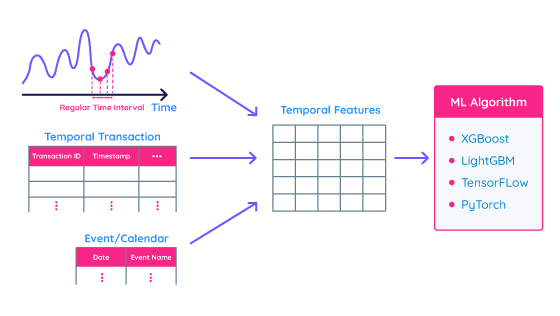


## Examples of temporal features: Aggregation of Lagged Values
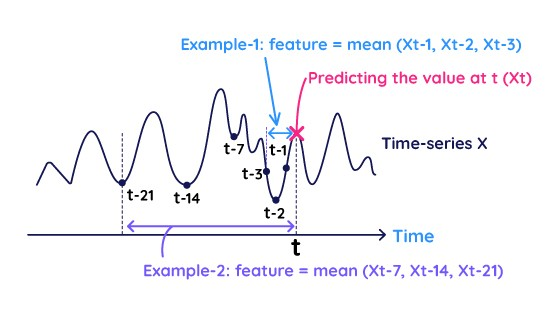

## Examples of temporal features: Time Interval
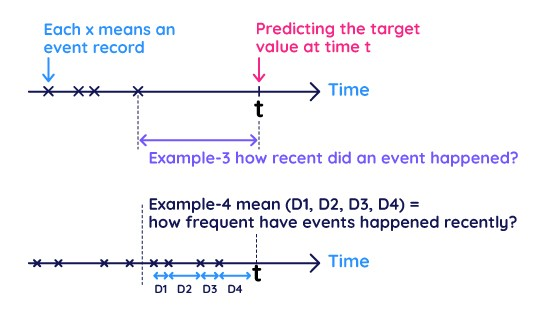

## 1. 載入套件與資料

為了清晰地演示時間衍生特徵的創建過程，我們將建立一個簡單的模擬時間序列數據集。這個數據集將包含一個時間戳欄位和一個隨機數值，足以展示如何從時間戳中提取各種有意義的時間組件，並將其轉化為模型可用的特徵。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # 保持與 module_05 一致的導入風格

# 設定視覺化風格 (保持一致性)
sns.set_style('whitegrid')

# 創建一個日期範圍，頻率為每4小時，涵蓋幾天
date_rng = pd.date_range(start='2023-01-01', end='2023-01-03 23:59:59', freq='4H')

# 創建 DataFrame，包含時間戳和一個模擬的數值 (例如，溫度、銷量等)
df = pd.DataFrame(date_rng, columns=['timestamp'])
df['value'] = np.random.randint(low=10, high=100, size=len(df)) # 添加一個示例數值列

# 確保 'timestamp' 欄位是 datetime 類型 (如果從 CSV 讀取，這一步尤其重要)
df['timestamp'] = pd.to_datetime(df['timestamp'])

print("原始模擬數據集載入成功！")
print("原始數據 (包含時間戳和模擬數值)：")
display(df.head())
print("\n資料類型概覽：")
display(df.info())



原始模擬數據集載入成功！
原始數據 (包含時間戳和模擬數值)：


,timestamp,value
0,2023-01-01 00:00:00,17
1,2023-01-01 04:00:00,90
2,2023-01-01 08:00:00,89
3,2023-01-01 12:00:00,36
4,2023-01-01 16:00:00,81



資料類型概覽：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  18 non-null     datetime64[ns]
 1   value      18 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 416.0 bytes


None

**結果解讀**：

我們的原始數據集非常簡潔，主要包含一個 `timestamp` 欄位和一個模擬的 `value`。`timestamp` 欄位目前是 `datetime64[ns]` 類型，這正是 `pandas` `dt` 訪問器所需的格式。接下來，我們將從這個時間戳中提取更多有用的信息。

## 2. 提取基本時間特徵：分解時間的各個維度

`pandas` 的 `dt` 訪問器提供了一種非常簡潔的方式，可以從 `datetime` 對象中直接提取出年、月、日、時、分、星期幾等基本時間組件。這些數值化的時間特徵可以被機器學習模型直接使用，幫助模型理解時間的各個方面。

In [3]:
print("正在提取基本時間特徵...")
df_time = df.copy()

df_time['year'] = df_time['timestamp'].dt.year
df_time['month'] = df_time['timestamp'].dt.month
df_time['day'] = df_time['timestamp'].dt.day
df_time['hour'] = df_time['timestamp'].dt.hour
df_time['minute'] = df_time['timestamp'].dt.minute
df_time['second'] = df_time['timestamp'].dt.second # 新增秒數特徵
df_time['dayofweek'] = df_time['timestamp'].dt.dayofweek # 星期一=0, 星期日=6
df_time['dayofyear'] = df_time['timestamp'].dt.dayofyear # 一年中的第幾天
df_time['weekofyear'] = df_time['timestamp'].dt.isocalendar().week.astype(int) # 一年中的第幾週，轉換為整數
df_time['quarter'] = df_time['timestamp'].dt.quarter # 季度

print("基本時間特徵提取完成！")
print("提取時間特徵後的 DataFrame (部分列)：")
display(df_time[['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'dayofweek', 'weekofyear', 'quarter']].head())



正在提取基本時間特徵...
基本時間特徵提取完成！
提取時間特徵後的 DataFrame (部分列)：


,timestamp,year,month,day,hour,minute,second,dayofweek,weekofyear,quarter
0,2023-01-01 00:00:00,2023,1,1,0,0,0,6,52,1
1,2023-01-01 04:00:00,2023,1,1,4,0,0,6,52,1
2,2023-01-01 08:00:00,2023,1,1,8,0,0,6,52,1
3,2023-01-01 12:00:00,2023,1,1,12,0,0,6,52,1
4,2023-01-01 16:00:00,2023,1,1,16,0,0,6,52,1


**結果解讀**：

現在，我們的 DataFrame 中增加了多個新的列，每個列都代表了時間戳的一個特定組件。例如，`dayofweek` 欄位可以幫助模型識別一週內的週期性模式（例如，週末與工作日的差異），而 `hour` 則能捕捉一天內的行為變化（例如，高峰時段）。這些數值化的特徵將原始時間戳的複雜性轉化為模型可以直接利用的資訊。

## 3. 創建布林型和自定義類別特徵：捕捉時間的「狀態」

除了直接提取數值，我們還可以根據時間創建更有意義的布林型（真/假）或自定義類別特徵。這些特徵能夠捕捉時間的特定「狀態」或「事件」，例如是否為週末、是否為節假日，或一天中的特定時段（早上、下午、晚上等）。

In [4]:
print("正在創建布林型和自定義類別時間特徵...")
# 是否為週末：星期六 (5) 或星期日 (6) 被定義為週末
df_time['is_weekend'] = (df_time['timestamp'].dt.dayofweek >= 5).astype(int)

# 一天中的時段 (自定義函數)：根據小時將一天分為幾個邏輯區間
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df_time['time_of_day'] = df_time['hour'].apply(get_time_of_day)

print("布林型和自定義類別時間特徵創建完成！")
print("創建自定義時間特徵後的 DataFrame (部分列)：")
display(df_time[['timestamp', 'is_weekend', 'time_of_day']].head())



正在創建布林型和自定義類別時間特徵...
布林型和自定義類別時間特徵創建完成！
創建自定義時間特徵後的 DataFrame (部分列)：


,timestamp,is_weekend,time_of_day
0,2023-01-01 00:00:00,1,Night
1,2023-01-01 04:00:00,1,Night
2,2023-01-01 08:00:00,1,Morning
3,2023-01-01 12:00:00,1,Afternoon
4,2023-01-01 16:00:00,1,Afternoon


**結果解讀**：

`is_weekend` 欄位是一個簡單的二元特徵，可以幫助模型區分週末和工作日的行為差異。`time_of_day` 則將一天劃分為幾個有意義的時段，這對於捕捉不同時段的行為模式（例如，早上通勤高峰、下午辦公時間、晚上娛樂時間）非常有用。這些特徵將時間的連續性轉化為模型更易於處理的離散狀態，提升了模型的辨識能力。

## 4. 計算時間差特徵：衡量事件之間的「流逝」

除了從時間戳本身提取組件，計算不同時間點之間的時間差也是一種非常有用的特徵工程技術。這種「時間流逝」特徵可以衡量事件之間的間隔長度，例如：客戶的上次購買距今多久、一個會話的持續時間、或故障發生距離上次維護的時間。這些特徵對於預測時間相關事件（如流失、下次購買時間、故障預測）尤其重要。

In [6]:
print("正在創建時間差特徵...")
# 計算距離數據集中第一個時間點過去了多少天/秒
# df['timestamp'].min() 獲取數據集中最早的時間戳
time_since_start = (df_time['timestamp'] - df_time['timestamp'].min())

# 將 Timedelta (時間差) 對象轉換為數值，例如總天數或總秒數
df_time['days_since_start'] = time_since_start.dt.days
df_time['seconds_since_start'] = time_since_start.dt.total_seconds()

print("時間差特徵創建完成！")
print("創建時間差特徵後的 DataFrame (部分列)：")
display(df_time[['timestamp', 'days_since_start', 'seconds_since_start']].head(10))



正在創建時間差特徵...
時間差特徵創建完成！
創建時間差特徵後的 DataFrame (部分列)：


,timestamp,days_since_start,seconds_since_start
0,2023-01-01 00:00:00,0,0.0
1,2023-01-01 04:00:00,0,14400.0
2,2023-01-01 08:00:00,0,28800.0
3,2023-01-01 12:00:00,0,43200.0
4,2023-01-01 16:00:00,0,57600.0
5,2023-01-01 20:00:00,0,72000.0
6,2023-01-02 00:00:00,1,86400.0
7,2023-01-02 04:00:00,1,100800.0
8,2023-01-02 08:00:00,1,115200.0
9,2023-01-02 12:00:00,1,129600.0


**結果解讀**：

`days_since_start` 和 `seconds_since_start` 欄位提供了從數據集開始到每個時間點的累積時間。這類特徵可以幫助模型捕捉趨勢或老化效應。例如，在客戶行為分析中，顧客距上次購買的時間越長，其流失的風險可能越高。這種時間差特徵為模型提供了時間上的「距離感」，使其能夠量化時間的影響。

## 5. 總結：駕馭時間的力量

時間衍生特徵是特徵工程中一項強大且必不可少的技能，尤其對於任何包含時間信息的資料集而言。它將原始、看似單一維度的時間戳，巧妙地轉化為機器學習模型可以輕鬆理解和利用的多維度信息，從而極大地提升了模型的預測性能和解釋性。本節我們學習了多種創建時間衍生特徵的實用方法：

| 特徵類型 | 實作方法 | 典型應用場景 | 核心價值 |
|:---|:---|:---|:---|
| **基本時間組件** | `dt.year`, `dt.month`, `dt.hour`, `dt.dayofweek` 等 | 季節性分析、每日/每週模式識別、趨勢捕捉 | 將時間分解為獨立的、可量化的單位 |
| **布林型/自定義類別** | `(dt.dayofweek >= 5)`, 自定義函數 `apply()` | 區分週末/工作日、高峰/非高峰時段、假日效應 | 捕捉時間的特定「狀態」或「事件」，提供情境資訊 |
| **時間差** | `(t2 - t1).dt.total_seconds()`, `dt.days` 等 | 客戶流失預測、故障預測、事件發生間隔分析 | 量化事件之間的「距離」或「流逝時間」，反映累積效應 |

在實際應用中，時間衍生特徵的創建應結合對業務問題的深入理解。例如，對於一個電商網站，可以考慮創建「用戶登錄距上次購買的天數」、「一天中首次登錄的小時數」等。通過巧妙地構造這些特徵，我們可以將時間的潛在預測力充分釋放，為機器學習模型帶來顯著的性能提升。


## 常見時間區間特徵轉換
## Nine different time domain feature extraction methods

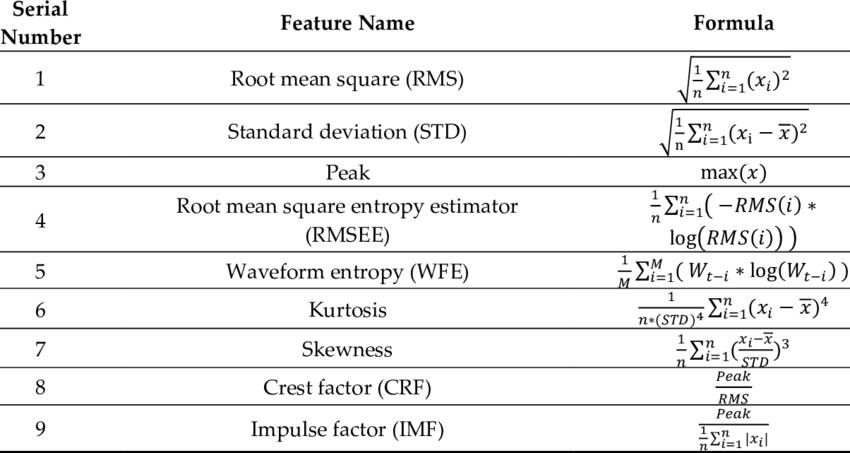


## 序列相依
https://www.kaggle.com/code/ryanholbrook/time-series-as-features

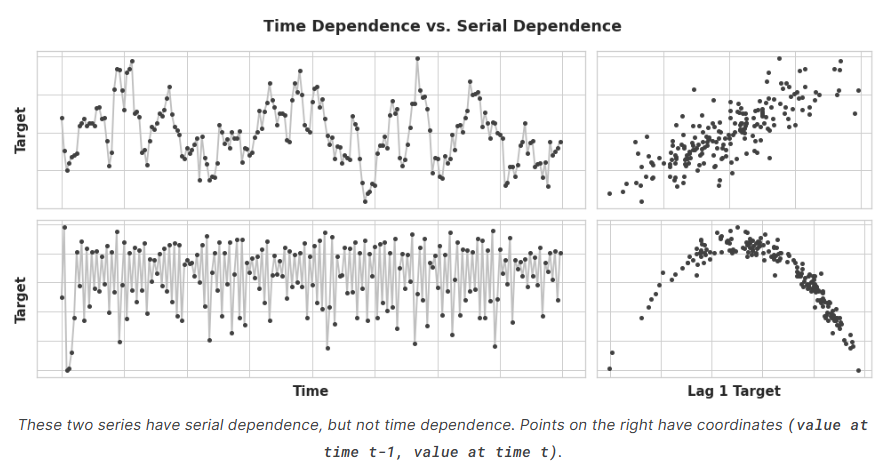


## catch22: CAnonical Time-series CHaracteristics
https://link.springer.com/article/10.1007/s10618-019-00647-x